# tobac example: Tracking deep convection based on VIS from geostationary satellite retrievals

This example notebook demonstrates the use of tobac to track isolated deep convective clouds based on radiances within the VIS using channel 2 (red light - 600 nm) of the GOES-16 imaging instrument in 5-min resolution. The study area is loacted within the CONUS extent of the GOES-E for investigating the formation of deep convection over the Carribean, following the EUREC4A initiative (http://eurec4a.eu/). 

The data used in this example is saved on the cloud of the Amazon Web Services, providing an efficient way of processing satellite data without facing the need of downloading the data. 

In this example, the [Cloud and Moisture Imagery data](https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.ncdc:C01502) (ABI-L2-CMIPC) data set is used for the cloud tracking. The product contains one or more Earth-view images with pixel values identifying brightness values that are scaled to support visual analysis. A resolution of 500 m in the VIS channels of the imager ensures a majority of features to be detectable. Also, the data includes quality information as well as information on the solar zenith angle. 

Further information on the AWS and provided data sets can be found [here](https://registry.opendata.aws/noaa-goes/).

---

## Accessing GOES data

**Configurations for conducting the example:**

In [2]:
# Import libraries:
import requests
import netCDF4
from tqdm import tqdm
import iris
import s3fs

import xarray
import rioxarray
import numpy as np
import pandas as pd
import os
from six.moves import urllib
from glob import glob

import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
# Import tobac itself:
import tobac

print("using tobac version", str(tobac.__version__))

using tobac version 1.5.0


In [4]:
# Disable a few warnings:
import warnings

warnings.filterwarnings("ignore", category=UserWarning, append=True)
warnings.filterwarnings("ignore", category=RuntimeWarning, append=True)
warnings.filterwarnings("ignore", category=FutureWarning, append=True)
warnings.filterwarnings("ignore", category=pd.io.pytables.PerformanceWarning)

**Build access to Amazon Web Server where GOES-16 data are stored:**

In [5]:
# For accessing data from AWS bucket first define specifics:
bucket_name = "noaa-goes16"
product_name = "ABI-L2-CMIPC"
year = 2020
day_of_year = 45
hour = 18
band = 2

In [6]:
# Initialize s3fs
fs = s3fs.S3FileSystem(anon=True)

In [7]:
# Generate file name pattern for the S3 bucket
prefix = f"{bucket_name}/{product_name}/{year}/{day_of_year:03d}/{hour:02d}/OR_{product_name}-M6C{band:02d}"

In [8]:
# Get keys using s3fs globbing
keys = fs.glob(f"{prefix}*")
keys = keys[:6]

**Request data from AWS S3 server using the keys and store all files to one data set:**

In [9]:
for k in tqdm(range(len(keys))):
    resp = requests.get(f"https://{bucket_name}.s3.amazonaws.com/{keys[k].split(bucket_name+'/')[1]}")
    file_name = keys[k].split("/")[-1].split(".")[0]
    nc4_ds = netCDF4.Dataset(file_name, memory=resp.content)
    store = xarray.backends.NetCDF4DataStore(nc4_ds)
    if k == 0:
        DS = xarray.open_dataset(store)
    else:
        DS2 = xarray.open_dataset(store)
        DS = xarray.combine_nested(
            [DS, DS2], concat_dim=["t"], combine_attrs="override"
        )

100%|██████████| 6/6 [00:42<00:00,  7.13s/it]


---

## Processing GOES data

**Reprojecting image coordinates:**

In [10]:
# Extract properties to define a projection string:
geos_p = DS["goes_imager_projection"]
proj_name = DS.goes_imager_projection.grid_mapping_name[0]
h = DS.goes_imager_projection.perspective_point_height
a = DS.goes_imager_projection.semi_major_axis
b = DS.goes_imager_projection.semi_minor_axis
rf = DS.goes_imager_projection.inverse_flattening
lat_0 = DS.goes_imager_projection.latitude_of_projection_origin
lon_0 = DS.goes_imager_projection.longitude_of_projection_origin
sweep = DS.goes_imager_projection.sweep_angle_axis
pstr = "+proj=geos +h=%f +a=%f +b=%f +rf=%f +lat_0=%f +lon_0=%f" % (
    h,
    a,
    b,
    rf,
    lat_0,
    lon_0,
)

In [11]:
DS = DS.rio.write_crs(pstr, inplace=True)

In [12]:
# Multiply the original coordinates by the satellite height:
DS["x"] = DS["x"] * h
DS["y"] = DS["y"] * h

In [13]:
# Reduce dataset to only variables needed for further analysis:
DS = DS[["CMI"]]

In [14]:
# Reproject to WGS84 (EPSG: 4326) using rasterio:
DS_R = DS.rio.reproject("epsg:4326")

In [15]:
# Change time precision from nanoseconds to microseconds so Iris can handle data after conversion
time_microseconds = pd.to_datetime(DS_R['t'].dt.strftime('%Y-%m-%d %H:%M:%S.%f'))
DS_R['t'] = time_microseconds
DS_R = DS_R.rename({'t': 'time'})

**Plot CONUS extent:**

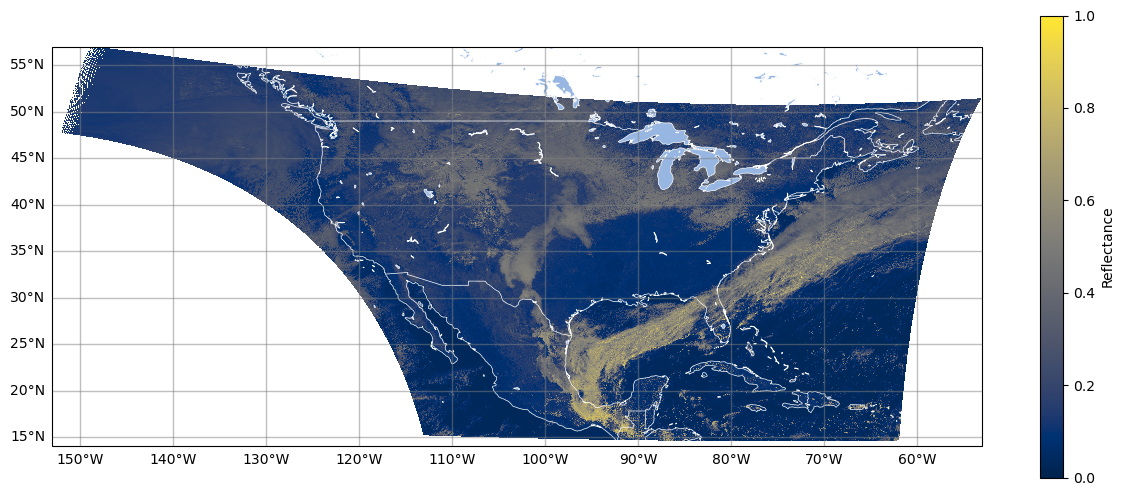

In [76]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker

fig = plt.figure(figsize=(15, 15))
ax_map = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax_map.set_extent([-153, -53, 14, 57], crs=ccrs.PlateCarree())

con = ax_map.pcolormesh(DS_R.x, DS_R.y, DS_R.CMI[0], cmap="cividis", vmin=0, vmax=1, transform=ccrs.PlateCarree())

ax_map.add_feature(cfeature.BORDERS, edgecolor="white", linewidth=0.5)
ax_map.add_feature(cfeature.COASTLINE, edgecolor="white", linewidth=0.5)
ax_map.add_feature(cfeature.LAKES, edgecolor="white", linewidth=0.5)

gl = ax_map.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='grey', alpha=0.5, linestyle='-')
gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.MaxNLocator(nbins=10, min_n_ticks=8, steps=None)
gl.ylocator = mticker.MaxNLocator(nbins=10, min_n_ticks=8, steps=None)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

plt.colorbar(con, shrink=0.4, label="Reflectance", ax=ax_map, orientation='vertical')

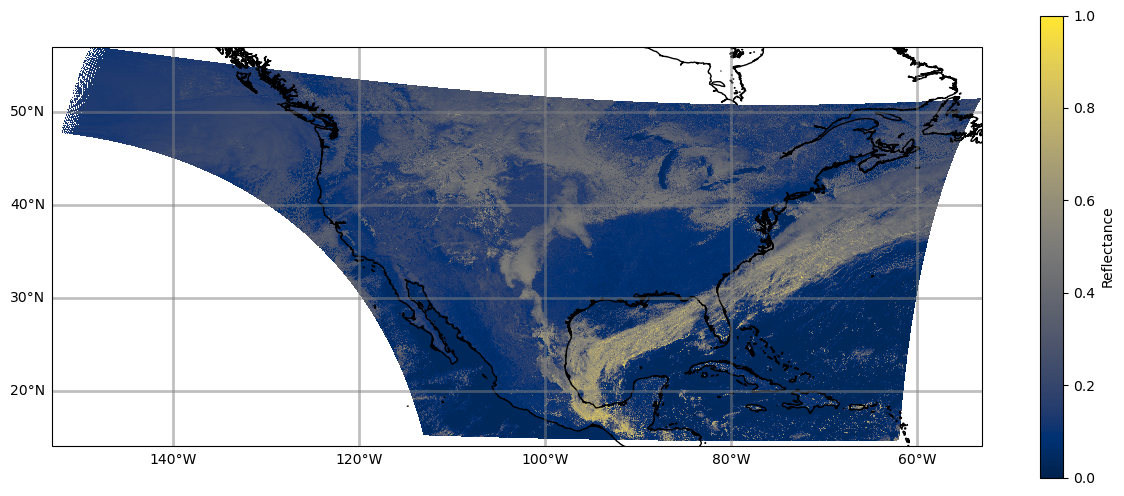

In [51]:
import cartopy.crs as ccrs

fig = plt.figure(figsize=(15, 15))
ax_map = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax_map.set_extent([-153, -53, 14, 57], crs=ccrs.PlateCarree())

ax_map = tobac.make_map(ax_map)
con = ax_map.pcolormesh(DS_R.x, DS_R.y, DS_R.CMI[0], cmap="cividis", vmin=0, vmax=1, transform=ccrs.PlateCarree())

plt.colorbar(con, shrink=0.4, label="Reflectance", ax=ax_map, orientation='vertical')

**Crop the image to a smaller extent, here focussing on the isle of Jamaica:**

In [55]:
# Define boundaries of mask used for cropping:
min_lon = -80.0
min_lat = 15.0
max_lon = -75.0
max_lat = 20.0

mask_lon = (DS_R.x >= min_lon) & (DS_R.x <= max_lon)
mask_lat = (DS_R.y >= min_lat) & (DS_R.y <= max_lat)

In [56]:
cropped_ds = DS_R.where(mask_lon & mask_lat, drop=True)

**Plot cropped image showing Jamaica:**

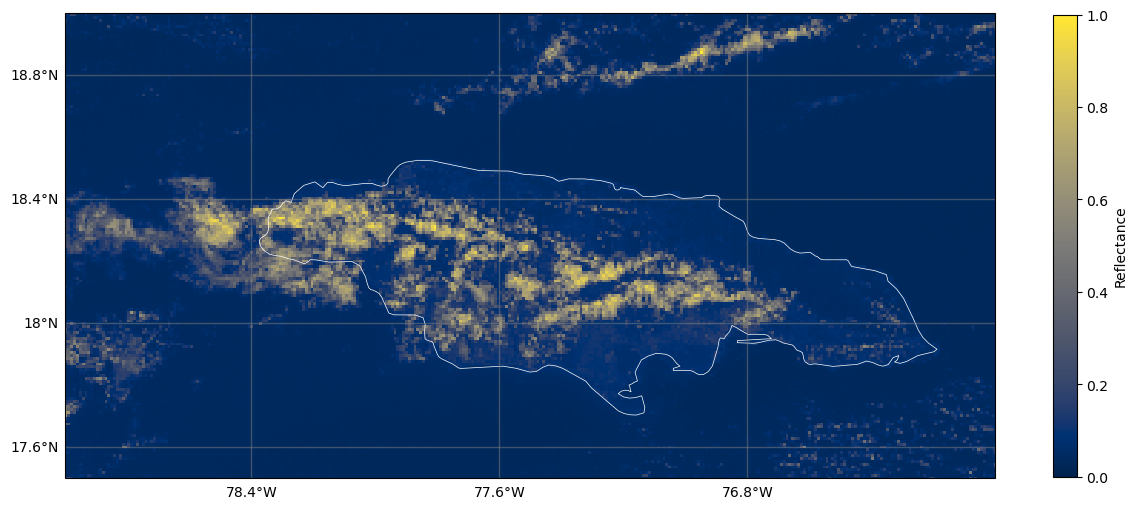

In [74]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker

fig = plt.figure(figsize=(15, 15))
ax_map = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax_map.set_extent([-79, -76, 17.5, 19], crs=ccrs.PlateCarree())

con = ax_map.pcolormesh(cropped_ds.x, cropped_ds.y, cropped_ds.CMI[0], cmap="cividis", vmin=0, vmax=1, transform=ccrs.PlateCarree())

ax_map.add_feature(cfeature.BORDERS, edgecolor="white", linewidth=0.5)
ax_map.add_feature(cfeature.COASTLINE, edgecolor="white", linewidth=0.5)
ax_map.add_feature(cfeature.LAKES, edgecolor="white", linewidth=0.5)

gl = ax_map.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='grey', alpha=0.5, linestyle='-')
gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.MaxNLocator(nbins=4, min_n_ticks=3, steps=None)
gl.ylocator = mticker.MaxNLocator(nbins=4, min_n_ticks=3, steps=None)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

plt.colorbar(con, shrink=0.4, label="Reflectance", ax=ax_map, orientation='vertical')

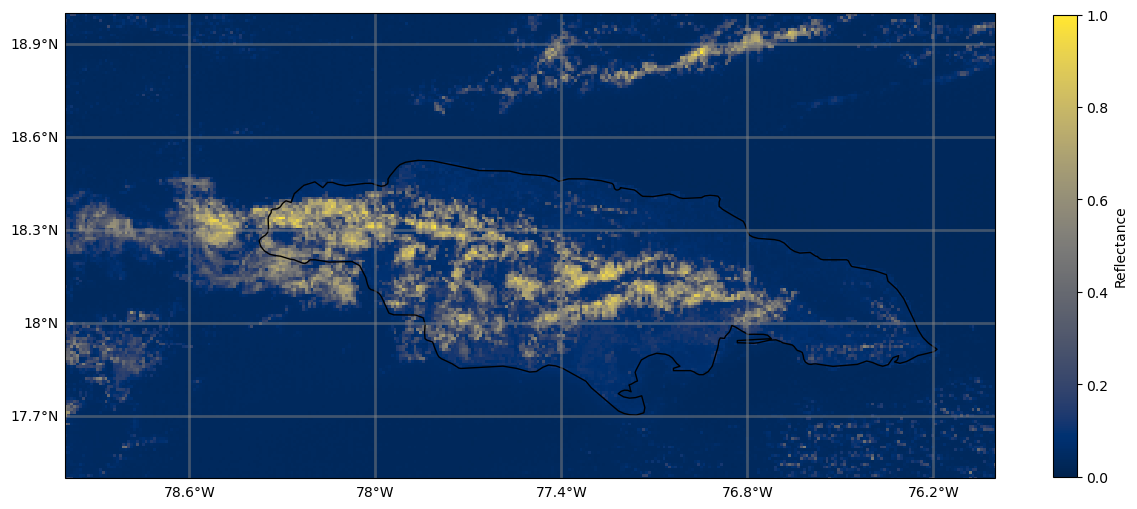

In [78]:
import cartopy.crs as ccrs

fig = plt.figure(figsize=(15, 15))
ax_map = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax_map.set_extent([-79, -76, 17.5, 19], crs=ccrs.PlateCarree())

ax_map = tobac.make_map(ax_map)
con = ax_map.pcolormesh(cropped_ds.x, cropped_ds.y, cropped_ds.CMI[0], cmap="cividis", vmin=0, vmax=1, transform=ccrs.PlateCarree())

plt.colorbar(con, shrink=0.4, label="Reflectance", ax=ax_map, orientation='vertical')

## Tobac Cloud Tracking

In [20]:
# Set up directory to save output and plots:
savedir = "Save"
if not os.path.exists(savedir):
    os.makedirs(savedir)
plot_dir = "Plot"
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

In [21]:
# Change standard_name to be a regular argument of cf-conventions:
cropped_ds.CMI.attrs["standard_name"] = "toa_bidirectional_reflectance"

In [22]:
# Assign former coordinates as variables to avoid dupplicate naming:
new_data = cropped_ds.reset_coords(names=["y_image", "x_image"])

**Feature identification:**
Identify features based on VIS field and a set of threshold values.

In [23]:
# Determine temporal and spatial sampling of the input data:
dxy, dt = tobac.utils.get_spacings(new_data.CMI, grid_spacing=500)

In [24]:
# Keyword arguments for the feature detection step:
parameters_features = {}
parameters_features["position_threshold"] = "weighted_diff"
parameters_features["sigma_threshold"] = 0.5
parameters_features["min_num"] = 8
parameters_features["n_min_threshold"] = 8
parameters_features["target"] = "maximum"
parameters_features["threshold"] = [0.2, 0.4, 0.6]

In [25]:
# Feature detection and save results to file:
print("starting feature detection")
Features = tobac.feature_detection_multithreshold(
    new_data.CMI, dxy, **parameters_features
)
Features.to_xarray().to_netcdf(os.path.join(savedir, "Features.nc"))
print("feature detection performed and saved")

starting feature detection
feature detection performed and saved


**Segmentation:**  
Segmentation is performed based on the OLR field and a threshold value to determine the cloud areas.

In [26]:
# Keyword arguments for the segmentation step:
parameters_segmentation = {}
parameters_segmentation["target"] = "maximum"
parameters_segmentation["method"] = "watershed"
parameters_segmentation["threshold"] = 0.2

In [27]:
# Perform segmentation and save results to files:
Mask_VIS, Features_VIS = tobac.segmentation_2D(
    Features, new_data.CMI, dxy, **parameters_segmentation
)

print("segmentation VIS performed, start saving results to files")
Mask_VIS.to_netcdf(os.path.join(savedir, "Mask_Segmentation_OLR.nc"))
Features_VIS.to_xarray().to_netcdf(os.path.join(savedir, "Features_VIS.nc"))
print("segmentation VIS performed and saved")

segmentation VIS performed, start saving results to files
segmentation VIS performed and saved


**Trajectory linking:**
The detected features are linked into cloud trajectories using the trackpy library (http://soft-matter.github.io/trackpy). This takes the feature positions determined in the feature detection step into account but does not include information on the shape of the identified objects.

In [28]:
# Keyword arguments for linking step:
parameters_linking = {}
parameters_linking["v_max"] = 20
parameters_linking["stubs"] = 2
parameters_linking["order"] = 1
parameters_linking["extrapolate"] = 0
parameters_linking["memory"] = 0
parameters_linking["adaptive_stop"] = 0.2
parameters_linking["adaptive_step"] = 0.95
parameters_linking["subnetwork_size"] = 100
parameters_linking["method_linking"] = "predict"

In [29]:
# Perform linking and save results to file:
Track = tobac.linking_trackpy(
    Features, new_data.CMI, dt=dt, dxy=dxy, **parameters_linking
)
Track.to_xarray().to_netcdf(os.path.join(savedir, "Track.nc"))

Frame 5: 260 trajectories present.


**Visualisation of the tracks:** 

In [30]:
axis_extent = [-79, -76, 17.5, 19]  # xmin,xmax,ymin,ymax

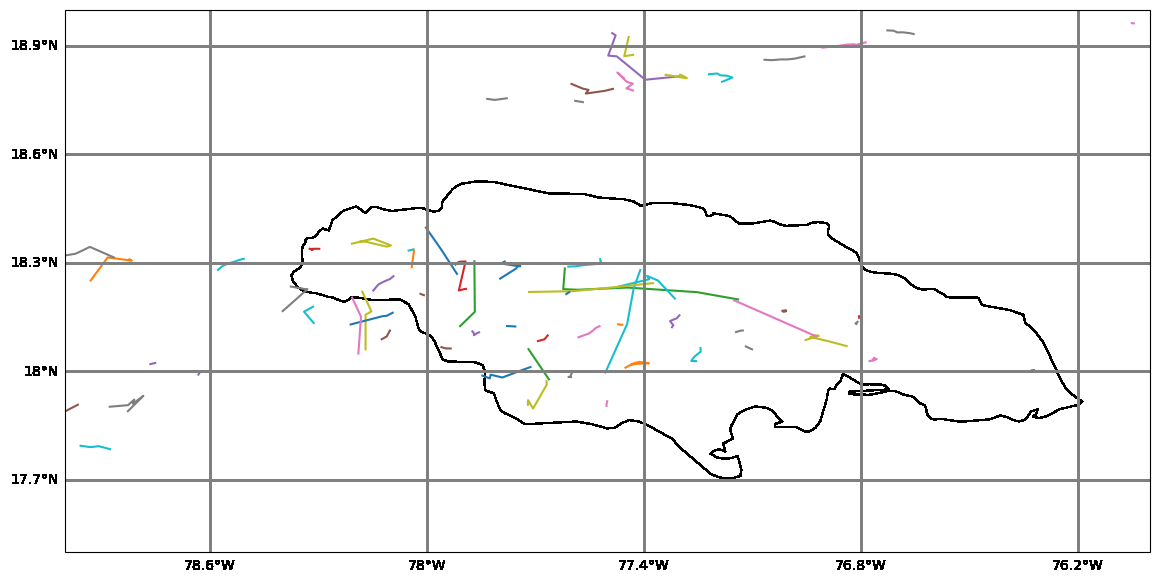

In [31]:
import cartopy.crs as ccrs

fig_map, ax_map = plt.subplots(
    figsize=(14, 8), subplot_kw={"projection": ccrs.PlateCarree()}
)
ax_map = tobac.map_tracks(Track, axis_extent=axis_extent, axes=ax_map)

In [32]:
# Create animation of tracked clouds and outlines with VIS as a background field:
animation_test_tobac = tobac.animation_mask_field(
    Track,
    Features,
    new_data.CMI.to_iris(),
    Mask_VIS.to_iris(),
    axis_extent=axis_extent,
    figsize=(14, 8),  # orientation_colorbar='horizontal',pad_colorbar=0.2,
    vmin=0,
    vmax=1,
    cmap="Blues_r",
    linewidth_contour=1,
    plot_outline=True,
    plot_marker=True,
    marker_track="x",
    plot_number=True,
    plot_features=True,
)

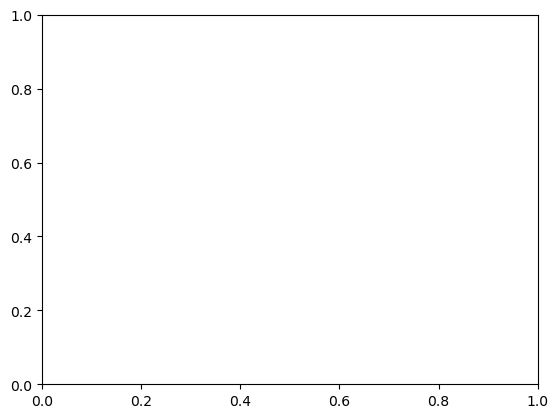

In [33]:
# Display animation:
from IPython.display import HTML, Image, display

HTML(animation_test_tobac.to_html5_video())

Text(0, 0.5, 'counts')

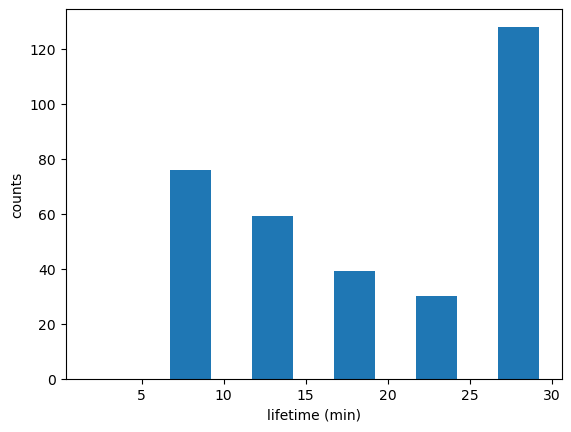

In [34]:
# Lifetimes of tracked clouds:
fig_lifetime, ax_lifetime = plt.subplots()
tobac.plot_lifetime_histogram_bar(
    Track, axes=ax_lifetime, bin_edges=np.arange(0, 35, 5), density=False, width_bar=2.5
)
ax_lifetime.set_xlabel("lifetime (min)")
ax_lifetime.set_ylabel("counts")